In [1]:
#from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Lambda, Multiply
from keras import backend as K
import cv2, numpy as np
import glob
from keras.optimizers import SGD, Adam
from keras.activations import relu 
import keras as keras
from keras.models import Model
from keras.layers import  Input,Conv2D,BatchNormalization,Activation,Lambda,Subtract,concatenate,Add,merge,add

from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose,DepthwiseConv2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
img_width, img_height = 640, 480
import os
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping 
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from  sklearn.model_selection import train_test_split

#from tensorflow.python import debug as tf_debug
import imageio
import glob
from skimage import transform as tf

from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib.image as plt_img
import scipy
import scipy
import skimage
import re
#import LRFinder
import math as m
import tensorflow as tf 
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler 
from keras import backend as K
from pathlib import Path
 
from keras import optimizers

import numpy as np
 
from keras import backend as K
from skimage.measure import compare_ssim, compare_psnr

import cv2
import numpy as np
from matplotlib import pyplot as plt

tf.random.Generator = None 
import tensorflow_addons as tfa
 

Using TensorFlow backend.


In [2]:
#from classifiers.vgg import VGGNet 

In [3]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential

In [4]:
num_classes = 10

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [5]:
import os

from keras.models import Model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras import backend as K

def conv_block(units, dropout=0.2, activation='relu', block=1, layer=1):

    def layer_wrapper(inp):
        x = Conv2D(units, (3, 3), padding='same', name='block{}_conv{}'.format(block, layer))(inp)
        x = BatchNormalization(name='block{}_bn{}'.format(block, layer))(x)
        x = Activation(activation, name='block{}_act{}'.format(block, layer))(x)
        x = Dropout(dropout, name='block{}_dropout{}'.format(block, layer))(x)
        return x

    return layer_wrapper

def dense_block(units, dropout=0.2, activation='relu', name='fc1'):

    def layer_wrapper(inp):
        x = Dense(units, name=name)(inp)
        x = BatchNormalization(name='{}_bn'.format(name))(x)
        x = Activation(activation, name='{}_act'.format(name))(x)
        x = Dropout(dropout, name='{}_dropout'.format(name))(x)
        return x

    return layer_wrapper
        

def VGG16_wBN(input_tensor=None, input_shape=None, classes=1000, conv_dropout=0.1, dropout=0.3, activation='relu'):
    """Instantiates the VGG16 architecture with Batch Normalization
    # Arguments
        input_tensor: Keras tensor (i.e. output of `layers.Input()`) to use as image input for the model.
        input_shape: shape tuple
        classes: optional number of classes to classify images
    # Returns
        A Keras model instance.
    """
    img_input = Input(shape=input_shape) if input_tensor is None else (
        Input(tensor=input_tensor, shape=input_shape) if not K.is_keras_tensor(input_tensor) else input_tensor
    )

    # Block 1
    x = conv_block(32, dropout=conv_dropout, activation=activation, block=1, layer=1)(img_input)
    x = conv_block(32, dropout=conv_dropout, activation=activation, block=1, layer=2)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = conv_block(64, dropout=conv_dropout, activation=activation, block=2, layer=1)(x)
    x = conv_block(64, dropout=conv_dropout, activation=activation, block=2, layer=2)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = conv_block(128, dropout=conv_dropout, activation=activation, block=3, layer=1)(x)
    x = conv_block(128, dropout=conv_dropout, activation=activation, block=3, layer=2)(x)
    x = conv_block(128, dropout=conv_dropout, activation=activation, block=3, layer=3)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = conv_block(256, dropout=conv_dropout, activation=activation, block=4, layer=1)(x)
    x = conv_block(256, dropout=conv_dropout, activation=activation, block=4, layer=2)(x)
    x = conv_block(256, dropout=conv_dropout, activation=activation, block=4, layer=3)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = conv_block(256, dropout=conv_dropout, activation=activation, block=5, layer=1)(x)
    x = conv_block(256, dropout=conv_dropout, activation=activation, block=5, layer=2)(x)
    x = conv_block(256, dropout=conv_dropout, activation=activation, block=5, layer=3)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    # Flatten
    x = GlobalAveragePooling2D()(x)

    # FC Layers
    x = dense_block(512, dropout=dropout, activation=activation, name='fc1')(x)
    x = dense_block(512, dropout=dropout, activation=activation, name='fc2')(x)
    
    # Classification block    
    x = Dense(classes, activation='softmax', name='predictions')(x)

    # Ensure that the model takes into account any potential predecessors of `input_tensor`.
    inputs = get_source_inputs(input_tensor) if input_tensor is not None else img_input

    # Create model.
    return Model(inputs, x, name='vgg16_bn')

In [6]:
from vgg_bn   import VGG16_BN
from vgg_wbn  import VGG16_wBN  
 

In [7]:
 
weight_decay = 1e-4
lr = 1e-1
num_classes = 10
model = VGG16_wBN(input_tensor=None, input_shape=x_train.shape[1:], classes=num_classes, conv_dropout=0.1, dropout=0.3, activation='relu')


In [8]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)
BATCHSIZE = 128
it_train = datagen.flow(x_train, y_train, batch_size=64)
steps = int(x_train.shape[0] / BATCHSIZE) 

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True)


filepath="Bv.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

#lr_scheduler = LearningRateScheduler(lr_scheduler)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint  ]

## Model Without Batch_norm

In [10]:
#optimizer = Adam(lr= 1e-3)


lra=[5e-3,1e-3,5e-4,1e-4]

ep=15
optimizer = Adam(lr= lra[0])
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
h1=model.fit(it_train,steps_per_epoch=steps,epochs=ep, validation_data=(x_test, y_test), callbacks = [checkpoint ]) 

optimizer = Adam(lr= lra[1])
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
h2=model.fit(it_train,steps_per_epoch=steps,epochs=ep, validation_data=(x_test, y_test), callbacks = [checkpoint ]) 

optimizer = Adam(lr= lra[2])
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
h3=model.fit(it_train,steps_per_epoch=steps,epochs=ep, validation_data=(x_test, y_test), callbacks = [checkpoint ]) 
 
optimizer = Adam(lr= lra[3])
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
h4=model.fit(it_train,steps_per_epoch=steps,epochs=ep, validation_data=(x_test, y_test), callbacks = [checkpoint ])     


Epoch 1/15
390/390 [==============================] - 13s 35ms/step - loss: 2.2095 - accuracy: 0.1797 - val_loss: 2.0475 - val_accuracy: 0.2081
Epoch 2/15
  7/390 [..............................] - ETA: 9s - loss: 2.0465 - accuracy: 0.2076

C:\Users\compu\Anaconda3\envs\Bdeep\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


390/390 [==============================] - 10s 27ms/step - loss: 2.0112 - accuracy: 0.1975 - val_loss: 2.1380 - val_accuracy: 0.1643
Epoch 3/15
390/390 [==============================] - 11s 28ms/step - loss: 1.9529 - accuracy: 0.2048 - val_loss: 1.9422 - val_accuracy: 0.2184
Epoch 4/15
390/390 [==============================] - 11s 27ms/step - loss: 1.9245 - accuracy: 0.2207 - val_loss: 1.9102 - val_accuracy: 0.2284
Epoch 5/15
390/390 [==============================] - 11s 28ms/step - loss: 1.9111 - accuracy: 0.2257 - val_loss: 1.8667 - val_accuracy: 0.2467
Epoch 6/15
390/390 [==============================] - 11s 27ms/step - loss: 1.8983 - accuracy: 0.2263 - val_loss: 1.8721 - val_accuracy: 0.2262
Epoch 7/15
390/390 [==============================] - 11s 28ms/step - loss: 1.8837 - accuracy: 0.2275 - val_loss: 1.9900 - val_accuracy: 0.2254
Epoch 8/15
390/390 [==============================] - 11s 27ms/step - loss: 1.8740 - accuracy: 0.2383 - val_loss: 2.0485 - val_accuracy: 0.1969
Epo

C:\Users\compu\Anaconda3\envs\Bdeep\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


390/390 [==============================] - 11s 28ms/step - loss: 1.6990 - accuracy: 0.3275 - val_loss: 1.6475 - val_accuracy: 0.3346
Epoch 3/15
390/390 [==============================] - 11s 28ms/step - loss: 1.6804 - accuracy: 0.3327 - val_loss: 1.6643 - val_accuracy: 0.3205
Epoch 4/15
390/390 [==============================] - 11s 28ms/step - loss: 1.6717 - accuracy: 0.3336 - val_loss: 1.6787 - val_accuracy: 0.3148
Epoch 5/15
390/390 [==============================] - 11s 29ms/step - loss: 1.6620 - accuracy: 0.3408 - val_loss: 1.5933 - val_accuracy: 0.3654
Epoch 6/15
390/390 [==============================] - 11s 28ms/step - loss: 1.6562 - accuracy: 0.3417 - val_loss: 1.6691 - val_accuracy: 0.3212
Epoch 7/15
390/390 [==============================] - 11s 29ms/step - loss: 1.6486 - accuracy: 0.3482 - val_loss: 1.6487 - val_accuracy: 0.3387
Epoch 8/15
390/390 [==============================] - 11s 28ms/step - loss: 1.6491 - accuracy: 0.3511 - val_loss: 1.6252 - val_accuracy: 0.3419
Epo

C:\Users\compu\Anaconda3\envs\Bdeep\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


390/390 [==============================] - 11s 29ms/step - loss: 1.5901 - accuracy: 0.3738 - val_loss: 1.5733 - val_accuracy: 0.3737
Epoch 3/15
390/390 [==============================] - 11s 28ms/step - loss: 1.5809 - accuracy: 0.3840 - val_loss: 1.5508 - val_accuracy: 0.3816
Epoch 4/15
390/390 [==============================] - 11s 28ms/step - loss: 1.5876 - accuracy: 0.3749 - val_loss: 1.5810 - val_accuracy: 0.3587
Epoch 5/15
390/390 [==============================] - 11s 28ms/step - loss: 1.5795 - accuracy: 0.3787 - val_loss: 1.5335 - val_accuracy: 0.3954
Epoch 6/15
390/390 [==============================] - 11s 28ms/step - loss: 1.5681 - accuracy: 0.3838 - val_loss: 1.5320 - val_accuracy: 0.3969
Epoch 7/15
390/390 [==============================] - 11s 28ms/step - loss: 1.5659 - accuracy: 0.3844 - val_loss: 1.5885 - val_accuracy: 0.3546
Epoch 8/15
390/390 [==============================] - 11s 28ms/step - loss: 1.5768 - accuracy: 0.3779 - val_loss: 1.5646 - val_accuracy: 0.3855
Epo

C:\Users\compu\Anaconda3\envs\Bdeep\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


390/390 [==============================] - 11s 29ms/step - loss: 1.5008 - accuracy: 0.4055 - val_loss: 1.5016 - val_accuracy: 0.3920
Epoch 3/15
390/390 [==============================] - 11s 28ms/step - loss: 1.4911 - accuracy: 0.4101 - val_loss: 1.4907 - val_accuracy: 0.3912
Epoch 4/15
390/390 [==============================] - 11s 28ms/step - loss: 1.4971 - accuracy: 0.4077 - val_loss: 1.4897 - val_accuracy: 0.3959
Epoch 5/15
390/390 [==============================] - 11s 28ms/step - loss: 1.4821 - accuracy: 0.4170 - val_loss: 1.5215 - val_accuracy: 0.3822
Epoch 6/15
390/390 [==============================] - 11s 28ms/step - loss: 1.4850 - accuracy: 0.4135 - val_loss: 1.4728 - val_accuracy: 0.4012
Epoch 7/15
390/390 [==============================] - 11s 29ms/step - loss: 1.4753 - accuracy: 0.4221 - val_loss: 1.5223 - val_accuracy: 0.3846
Epoch 8/15
390/390 [==============================] - 11s 29ms/step - loss: 1.4740 - accuracy: 0.4264 - val_loss: 1.4925 - val_accuracy: 0.3938
Epo

In [11]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

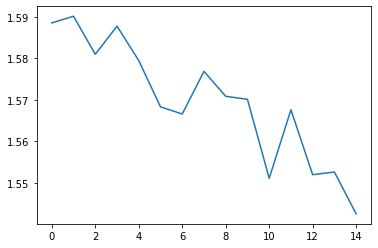

In [12]:
 plt.plot(h3.history["loss"], label="Training Loss") 

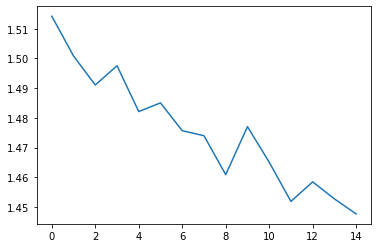

In [13]:
 plt.plot(h4.history["loss"], label="Training Loss")

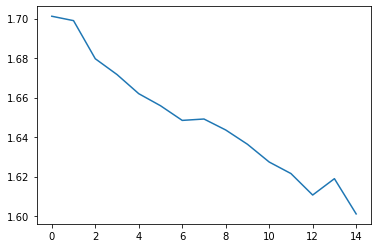

In [14]:
plt.plot(h2.history["loss"], label="Training Loss")

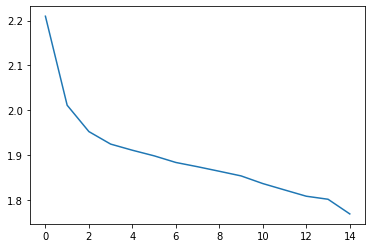

In [15]:
 plt.plot(h1.history["loss"], label="Training Loss")

In [16]:
l1 = np.array(h1.history["loss"]) 
l2 = np.array(h2.history["loss"]) 
l3 = np.array(h3.history["loss"]) 
l4 = np.array(h4.history["loss"]) 

In [17]:
min_curve = []
max_curve = []
for i in range(len(l1)):
    min_curve.append(np.min([l1[i], l2[i], l3[i], l4[i]]))
    max_curve.append(np.max([l1[i], l2[i], l3[i], l4[i]]))

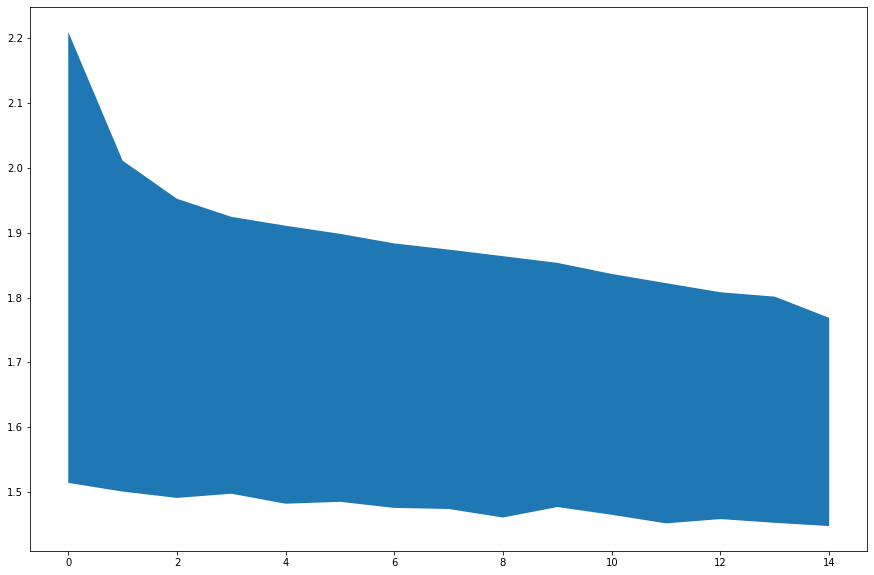

In [18]:
plt.figure(figsize=(15, 10))
plt.fill_between(range(len(min_curve)), min_curve, max_curve) 

## Model With Batch_norm


In [19]:
model = VGG16_BN(input_tensor=None, input_shape=x_train.shape[1:], classes=num_classes, conv_dropout=0.1, dropout=0.3, activation='relu')

In [20]:
#optimizer = Adam(lr= 1e-3)


lra=[5e-3,1e-3,5e-4,1e-4]

ep=15
optimizer = Adam(lr= lra[0])
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
hb1=model.fit(it_train,steps_per_epoch=steps,epochs=ep, validation_data=(x_test, y_test), callbacks = [checkpoint ]) 

optimizer = Adam(lr= lra[1])
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
hb2=model.fit(it_train,steps_per_epoch=steps,epochs=ep, validation_data=(x_test, y_test), callbacks = [checkpoint ]) 

optimizer = Adam(lr= lra[2])
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
hb3=model.fit(it_train,steps_per_epoch=steps,epochs=ep, validation_data=(x_test, y_test), callbacks = [checkpoint ]) 
 
optimizer = Adam(lr= lra[3])
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
hb4=model.fit(it_train,steps_per_epoch=steps,epochs=ep, validation_data=(x_test, y_test), callbacks = [checkpoint ])     


Epoch 1/15
390/390 [==============================] - 23s 60ms/step - loss: 2.2361 - accuracy: 0.1814 - val_loss: 3.7925 - val_accuracy: 0.1193
Epoch 2/15
  3/390 [..............................] - ETA: 16s - loss: 2.0568 - accuracy: 0.1719

C:\Users\compu\Anaconda3\envs\Bdeep\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


390/390 [==============================] - 19s 49ms/step - loss: 2.0396 - accuracy: 0.2051 - val_loss: 3.4050 - val_accuracy: 0.1882
Epoch 3/15
390/390 [==============================] - 19s 49ms/step - loss: 1.9111 - accuracy: 0.2606 - val_loss: 1.8120 - val_accuracy: 0.2813
Epoch 4/15
390/390 [==============================] - 19s 49ms/step - loss: 1.7200 - accuracy: 0.3428 - val_loss: 1.5976 - val_accuracy: 0.3798
Epoch 5/15
390/390 [==============================] - 19s 49ms/step - loss: 1.6353 - accuracy: 0.3760 - val_loss: 1.6652 - val_accuracy: 0.3543
Epoch 6/15
390/390 [==============================] - 19s 49ms/step - loss: 1.5189 - accuracy: 0.4271 - val_loss: 1.6024 - val_accuracy: 0.4248
Epoch 7/15
390/390 [==============================] - 19s 49ms/step - loss: 1.4281 - accuracy: 0.4727 - val_loss: 1.4844 - val_accuracy: 0.4494
Epoch 8/15
390/390 [==============================] - 19s 49ms/step - loss: 1.3438 - accuracy: 0.5191 - val_loss: 1.4885 - val_accuracy: 0.4698
Epo

C:\Users\compu\Anaconda3\envs\Bdeep\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


390/390 [==============================] - 20s 50ms/step - loss: 0.7662 - accuracy: 0.7450 - val_loss: 0.8166 - val_accuracy: 0.7218
Epoch 3/15
390/390 [==============================] - 19s 50ms/step - loss: 0.7510 - accuracy: 0.7480 - val_loss: 0.6886 - val_accuracy: 0.7656
Epoch 4/15
390/390 [==============================] - 19s 50ms/step - loss: 0.7470 - accuracy: 0.7525 - val_loss: 0.6627 - val_accuracy: 0.7761
Epoch 5/15
390/390 [==============================] - 19s 50ms/step - loss: 0.7265 - accuracy: 0.7612 - val_loss: 0.7156 - val_accuracy: 0.7560
Epoch 6/15
390/390 [==============================] - 19s 50ms/step - loss: 0.7184 - accuracy: 0.7631 - val_loss: 0.6370 - val_accuracy: 0.7878
Epoch 7/15
390/390 [==============================] - 20s 50ms/step - loss: 0.7057 - accuracy: 0.7667 - val_loss: 0.6469 - val_accuracy: 0.7816
Epoch 8/15
390/390 [==============================] - 20s 50ms/step - loss: 0.6859 - accuracy: 0.7737 - val_loss: 0.7149 - val_accuracy: 0.7587
Epo

C:\Users\compu\Anaconda3\envs\Bdeep\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


390/390 [==============================] - 19s 48ms/step - loss: 0.5946 - accuracy: 0.8033 - val_loss: 0.5990 - val_accuracy: 0.7996
Epoch 3/15
390/390 [==============================] - 19s 48ms/step - loss: 0.5898 - accuracy: 0.8041 - val_loss: 0.6109 - val_accuracy: 0.7978
Epoch 4/15
390/390 [==============================] - 19s 47ms/step - loss: 0.5778 - accuracy: 0.8123 - val_loss: 0.6450 - val_accuracy: 0.7912
Epoch 5/15
390/390 [==============================] - 19s 48ms/step - loss: 0.5889 - accuracy: 0.8082 - val_loss: 0.5634 - val_accuracy: 0.8130
Epoch 6/15
390/390 [==============================] - 19s 48ms/step - loss: 0.5705 - accuracy: 0.8127 - val_loss: 0.6448 - val_accuracy: 0.7899
Epoch 7/15
390/390 [==============================] - 19s 48ms/step - loss: 0.5506 - accuracy: 0.8214 - val_loss: 0.5755 - val_accuracy: 0.8139
Epoch 8/15
390/390 [==============================] - 19s 48ms/step - loss: 0.5642 - accuracy: 0.8148 - val_loss: 0.6068 - val_accuracy: 0.8012
Epo

C:\Users\compu\Anaconda3\envs\Bdeep\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


390/390 [==============================] - 19s 48ms/step - loss: 0.5008 - accuracy: 0.8375 - val_loss: 0.5737 - val_accuracy: 0.8136
Epoch 3/15
390/390 [==============================] - 19s 48ms/step - loss: 0.5001 - accuracy: 0.8357 - val_loss: 0.5677 - val_accuracy: 0.8156
Epoch 4/15
390/390 [==============================] - 19s 48ms/step - loss: 0.5113 - accuracy: 0.8313 - val_loss: 0.5856 - val_accuracy: 0.8109
Epoch 5/15
390/390 [==============================] - 19s 49ms/step - loss: 0.5012 - accuracy: 0.8375 - val_loss: 0.5917 - val_accuracy: 0.8087
Epoch 6/15
390/390 [==============================] - 19s 48ms/step - loss: 0.5083 - accuracy: 0.8320 - val_loss: 0.5759 - val_accuracy: 0.8155
Epoch 7/15
390/390 [==============================] - 19s 48ms/step - loss: 0.5014 - accuracy: 0.8361 - val_loss: 0.5588 - val_accuracy: 0.8176
Epoch 8/15
390/390 [==============================] - 19s 48ms/step - loss: 0.4999 - accuracy: 0.8349 - val_loss: 0.5709 - val_accuracy: 0.8156
Epo

In [21]:
lb1 = np.array(hb1.history["loss"]) 
lb2 = np.array(hb2.history["loss"]) 
lb3 = np.array(hb3.history["loss"]) 
lb4 = np.array(hb4.history["loss"]) 

In [22]:
min_curveb = []
max_curveb = []
for i in range(len(lb1)):
    min_curveb.append(np.min([lb1[i], lb2[i], lb3[i], lb4[i]]))
    max_curveb.append(np.max([lb1[i], lb2[i], lb3[i], lb4[i]]))

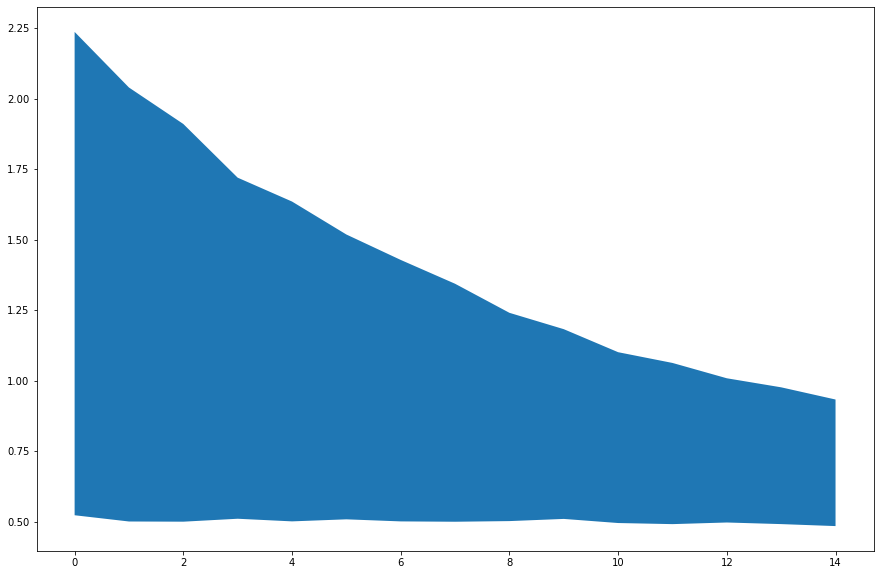

In [23]:
plt.figure(figsize=(15, 10))
plt.fill_between(range(len(min_curveb)), min_curveb, max_curveb) 

C:\Users\compu\Anaconda3\envs\Bdeep\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later


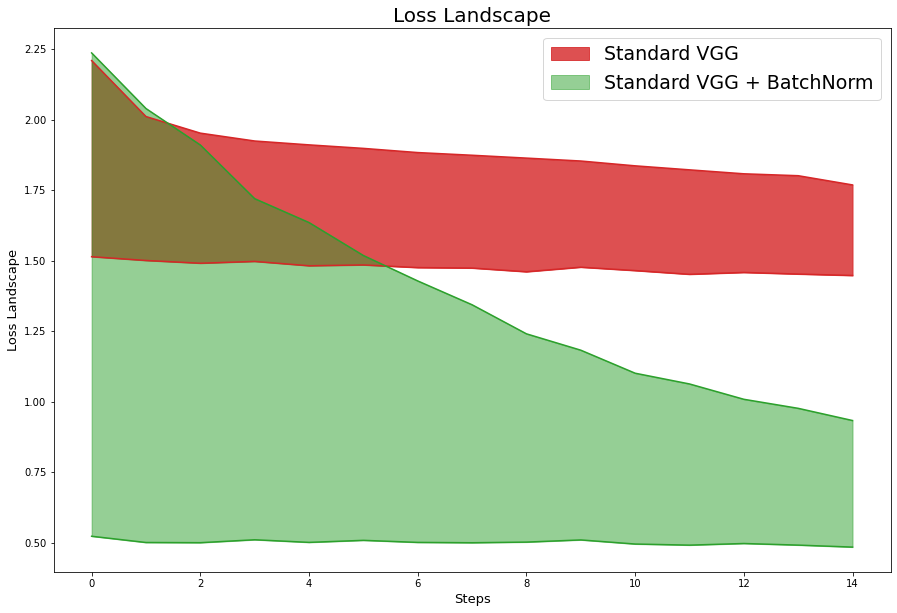

In [52]:
figures_path='fig/'
step = 1
steps = np.arange(0, len(min_curve), step)
plt.figure(figsize=(15, 10))
plt.fill_between(steps, min_curve[::step], max_curve[::step],
                alpha=.81, color='C3', label='Standard VGG')
plt.plot(steps, min_curve[::step], color='C3')
plt.plot(steps, max_curve[::step], color='C3')

plt.fill_between(steps, min_curveb[::step], max_curveb[::step],
                alpha=0.5, color='C2', label='Standard VGG + BatchNorm')
plt.plot(steps, min_curveb[::step], color='C2')
plt.plot(steps, max_curveb[::step], color='C2')

plt.legend(fontsize=19)
plt.title('Loss Landscape', fontsize=20)
plt.ylabel('Loss Landscape', fontsize=13)
plt.xlabel('Steps', fontsize=13)
plt.savefig(os.path.join(figures_path, 'loss_landscape.png'), dpi=500, quality=100)
plt.show()